Simulating VAR Data for Bayesian Estimation
VAR MODEL INFORMATION
Dimensions: N=3 variables, p=2 lags, T=1002 observations

Constants (μ):
[ 0.04967142 -0.01382643  0.06476885]

AR Coefficients A1:
[[ 0.7        -0.06879627 -0.0688011 ]
 [-0.08838328  0.7         0.07323523]
 [ 0.020223    0.04161452  0.7       ]]

AR Coefficients A2:
[[-0.2876493   0.28194591  0.19946558]
 [-0.17259653 -0.19090502 -0.18995729]
 [-0.11745465  0.01485386 -0.04083299]]

Error Covariance (Σ):
[[ 1.         -0.02187515 -0.26411003]
 [-0.02187515  1.          0.11283227]
 [-0.26411003  0.11283227  1.        ]]

Data Summary:
Mean: [-0.03507968 -0.18900753  0.28615067]
Std:  [1.44061299 1.43957979 1.40279666]

Design Matrices:
Y_matrix shape: (1000, 3)
X_matrix shape: (1000, 7)
K (total regressors): 7


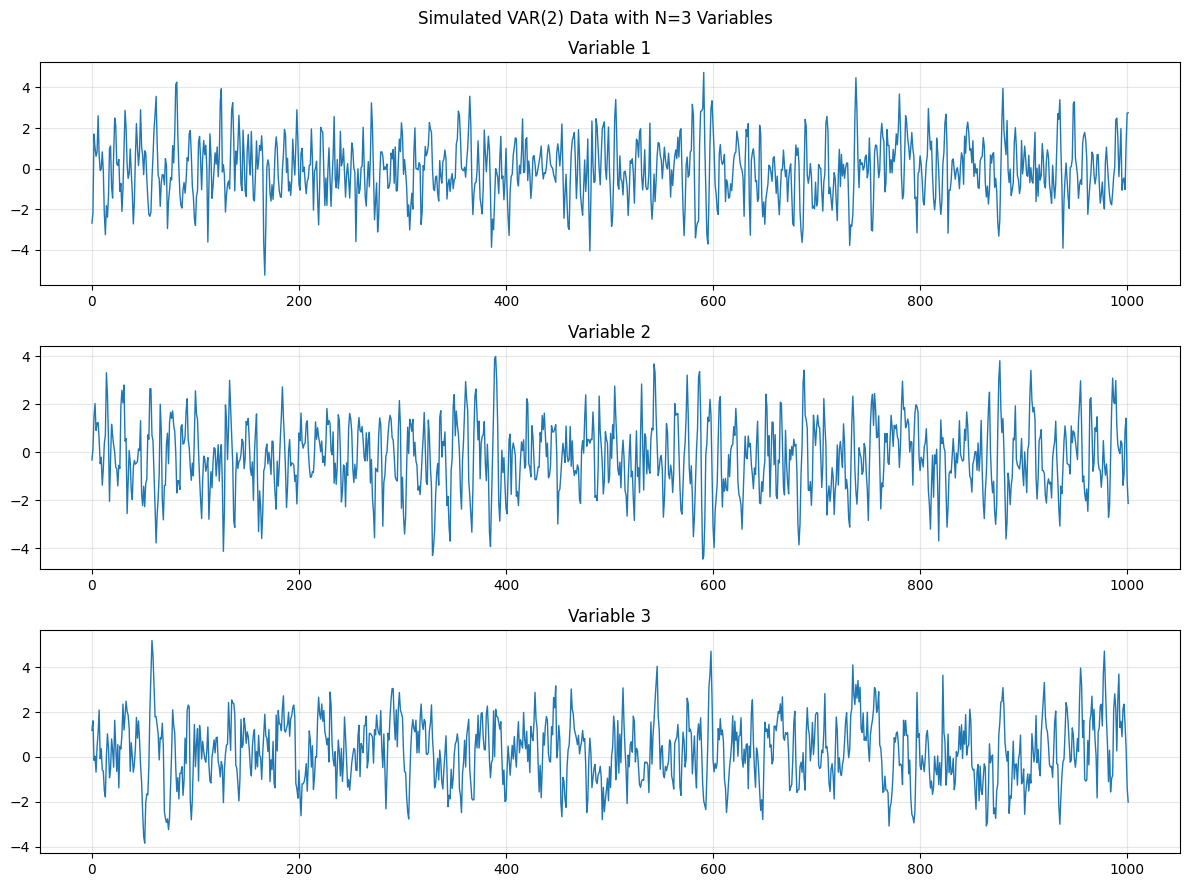


DataFrame created:
            y1        y2        y3
time                              
0    -2.677009 -0.316799  1.180473
1    -2.187928  0.123147  1.608976
2     1.707364  1.488523 -0.148518
3     1.027383  2.035054  0.030674
4     0.611106  0.915317 -0.674406

DataFrame info:
                y1           y2           y3
count  1002.000000  1002.000000  1002.000000
mean     -0.035080    -0.189008     0.286151
std       1.441332     1.440299     1.403497
min      -5.238606    -4.447078    -3.839269
25%      -0.967462    -1.141142    -0.637558
50%      -0.056998    -0.215329     0.299860
75%       0.838376     0.803808     1.239715
max       4.734963     3.995332     5.186342

Data simulation completed!
Variables available:
- Y: simulated data (T x N)
- Y_matrix: dependent vars for estimation
- X_matrix: regressors for estimation
- mu_true, A_true, Sigma_true: true parameters
- df: pandas DataFrame of the data


In [1]:
# Simulating data

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seed
np.random.seed(42)

def generate_var_coefficients(N, p, persistence=0.7, cross_effects=0.1):
    """
    Generate VAR coefficients A1, A2, ..., Ap
    
    Parameters:
    N : jumlah variabel
    p : jumlah lag
    persistence : diagonal elements A1 (autoregressive effect)
    cross_effects : off-diagonal elements
    """
    A = np.zeros((N, N, p))
    
    # A1: persistence di diagonal, cross-effects di off-diagonal
    A[:, :, 0] = persistence * np.eye(N)
    np.fill_diagonal(A[:, :, 0], persistence)
    
    # Add cross effects
    for i in range(N):
        for j in range(N):
            if i != j:
                A[i, j, 0] = np.random.uniform(-cross_effects, cross_effects)
    
    # A2, A3, ..., Ap dengan efek yang menurun
    for lag in range(1, p):
        decay = 0.3 / lag  # Efek menurun
        A[:, :, lag] = np.random.uniform(-decay, decay, (N, N))
    
    return A

def generate_covariance_matrix(N, correlation=0.3):
    """Generate positive definite covariance matrix"""
    if N == 1:
        return np.array([[1.0]])
    
    # Generate random correlation
    R = np.random.randn(N, N)
    R = R @ R.T
    
    # Normalize to correlation matrix
    d = np.sqrt(np.diag(R))
    R = R / np.outer(d, d)
    
    # Apply correlation strength
    Sigma = (1 - correlation) * np.eye(N) + correlation * R
    
    return Sigma

def simulate_var_data(N, p, T, mu=None, A=None, Sigma=None, burn_in=100):
    """
    Simulate VAR(p) data
    
    Parameters:
    N : jumlah variabel
    p : jumlah lag  
    T : sample size
    mu : konstanta (N x 1)
    A : AR coefficients (N x N x p)
    Sigma : error covariance (N x N)
    burn_in : observasi awal yang dibuang
    """
    # Set default parameters
    if mu is None:
        mu = np.random.normal(0, 0.1, N)
    
    if A is None:
        A = generate_var_coefficients(N, p)
    
    if Sigma is None:
        Sigma = generate_covariance_matrix(N)
    
    # Total sample dengan burn-in
    total_T = T + burn_in + p
    Y = np.zeros((total_T, N))
    
    # Initial conditions
    for t in range(p):
        Y[t, :] = np.random.multivariate_normal(mu, Sigma)
    
    # Generate VAR process
    for t in range(p, total_T):
        # AR component
        ar_part = np.zeros(N)
        for lag in range(p):
            ar_part += A[:, :, lag] @ Y[t-1-lag, :]
        
        # Mean + AR + Error
        mean_t = mu + ar_part
        error_t = np.random.multivariate_normal(np.zeros(N), Sigma)
        Y[t, :] = mean_t + error_t
    
    # Remove burn-in
    Y_final = Y[burn_in:, :]
    
    return Y_final, mu, A, Sigma

def create_design_matrices(Y, p):
    """
    Create design matrices for VAR estimation
    
    Returns:
    Y_matrix : (T-p) x N dependent variables
    X_matrix : (T-p) x K regressors [1, y_{t-1}, ..., y_{t-p}]
    """
    T, N = Y.shape
    T_effective = T - p
    K = 1 + p * N  # konstanta + p lags * N variables
    
    # Y matrix (dependent variables)
    Y_matrix = Y[p:, :]
    
    # X matrix (regressors)
    X_matrix = np.zeros((T_effective, K))
    
    for t in range(T_effective):
        col_idx = 0
        
        # Konstanta
        X_matrix[t, col_idx] = 1
        col_idx += 1
        
        # Lagged variables
        for lag in range(p):
            Y_lag = Y[p + t - 1 - lag, :]  # y_{t-1-lag}
            X_matrix[t, col_idx:col_idx+N] = Y_lag
            col_idx += N
    
    return Y_matrix, X_matrix

def plot_var_data(Y, title="Simulated VAR Data"):
    """Plot time series data"""
    T, N = Y.shape
    
    fig, axes = plt.subplots(N, 1, figsize=(12, 3*N))
    if N == 1:
        axes = [axes]
    
    for i in range(N):
        axes[i].plot(Y[:, i], linewidth=1)
        axes[i].set_title(f'Variable {i+1}')
        axes[i].grid(True, alpha=0.3)
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def print_var_info(Y, mu, A, Sigma):
    """Print VAR model information"""
    T, N = Y.shape
    p = A.shape[2]
    
    print("="*50)
    print("VAR MODEL INFORMATION")
    print("="*50)
    print(f"Dimensions: N={N} variables, p={p} lags, T={T} observations")
    print(f"\nConstants (μ):")
    print(mu)
    print(f"\nAR Coefficients A1:")
    print(A[:, :, 0])
    if p > 1:
        print(f"\nAR Coefficients A2:")
        print(A[:, :, 1])
    print(f"\nError Covariance (Σ):")
    print(Sigma)
    print(f"\nData Summary:")
    print(f"Mean: {np.mean(Y, axis=0)}")
    print(f"Std:  {np.std(Y, axis=0)}")

# =============================================================================
# IMPLEMENTASI
# =============================================================================

print("Simulating VAR Data for Bayesian Estimation")
print("=" * 50)

# Parameter simulasi
N = 3      # 3 variabel
p = 2      # VAR(2)  
T = 1000    # 1000 observasi

# Simulate data
Y, mu_true, A_true, Sigma_true = simulate_var_data(N, p, T)

# Print info
print_var_info(Y, mu_true, A_true, Sigma_true)

# Create design matrices untuk estimasi
Y_matrix, X_matrix = create_design_matrices(Y, p)

print(f"\nDesign Matrices:")
print(f"Y_matrix shape: {Y_matrix.shape}")  
print(f"X_matrix shape: {X_matrix.shape}")
print(f"K (total regressors): {X_matrix.shape[1]}")

# Plot data
plot_var_data(Y, "Simulated VAR(2) Data with N=3 Variables")

# Create DataFrame untuk analisis lebih lanjut
df = pd.DataFrame(Y, columns=[f'y{i+1}' for i in range(N)])
df.index.name = 'time'

print(f"\nDataFrame created:")
print(df.head())
print(f"\nDataFrame info:")
print(df.describe())

print("\n" + "="*50)
print("Data simulation completed!")
print("Variables available:")
print("- Y: simulated data (T x N)")  
print("- Y_matrix: dependent vars for estimation")
print("- X_matrix: regressors for estimation")
print("- mu_true, A_true, Sigma_true: true parameters")
print("- df: pandas DataFrame of the data")
print("="*50)

Setting up Minnesota Prior Distribution
Minnesota Prior Setup:
λ₀ (konstanta shrinkage): 1.0
λ₁ (AR shrinkage): 0.2
ν (degrees of freedom): 5
Univariate AR variances: [1.38092579 1.21833828 1.0613324 ]
A_bar shape: (7, 3)
V shape: (7, 7)
S shape: (3, 3)

Prior Mean A_bar:
[[0. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

Prior Covariance V (diagonal elements):
[1.         0.14483037 0.16415802 0.18844238 0.03620759 0.0410395
 0.04711059]

Prior Scale Matrix S:
[[1.38092579 0.         0.        ]
 [0.         1.21833828 0.        ]
 [0.         0.         1.0613324 ]]


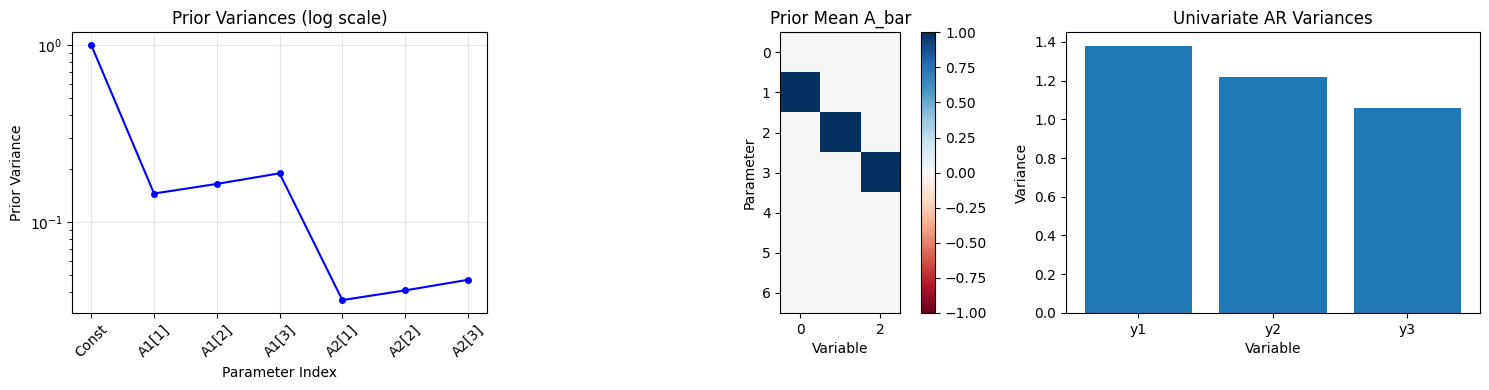


Minnesota Prior Setup Completed!
Key Components:
- A_bar: Random walk prior mean
- V: Shrinkage covariance matrix
- S_prior: Scale matrix for Σ
- nu: Degrees of freedom
Ready for Bayesian inference!


In [2]:
# Minnesota Prior

import numpy as np
from scipy import linalg
from scipy.stats import invwishart
import matplotlib.pyplot as plt

def estimate_univariate_ar_variances(Y, p=1):
    """
    Estimate univariate AR error variances untuk Minnesota prior
    
    Parameters:
    Y : (T, N) data matrix
    p : lag order untuk univariate AR
    
    Returns:
    sigma_hat_squared : (N,) array of error variances
    """
    T, N = Y.shape
    sigma_hat_squared = np.zeros(N)
    
    for i in range(N):
        y = Y[:, i]
        
        # Create lagged data untuk univariate AR(p)
        y_dep = y[p:]
        X_ar = np.column_stack([np.ones(len(y_dep))] + 
                              [y[p-j:-j] for j in range(1, p+1)])
        
        # OLS regression
        beta = linalg.inv(X_ar.T @ X_ar) @ X_ar.T @ y_dep
        residuals = y_dep - X_ar @ beta
        
        # Error variance
        sigma_hat_squared[i] = np.var(residuals, ddof=p+1)
    
    return sigma_hat_squared

def create_minnesota_prior_V(N, p, lambda_0, lambda_1, sigma_hat_squared):
    """
    Create Minnesota prior covariance matrix V
    
    Parameters:
    N : jumlah variabel
    p : lag order
    lambda_0 : shrinkage parameter untuk konstanta
    lambda_1 : shrinkage parameter untuk AR coefficients  
    sigma_hat_squared : (N,) univariate AR error variances
    
    Returns:
    V : (K, K) prior covariance matrix (diagonal)
    """
    K = 1 + p * N
    V = np.zeros((K, K))
    
    # Konstanta (first element)
    V[0, 0] = lambda_0
    
    # AR coefficients
    idx = 1
    for lag in range(1, p + 1):  # lag = 1, 2, ..., p
        for var in range(N):     # variable = 1, 2, ..., N
            V[idx, idx] = lambda_1 / (lag**2 * sigma_hat_squared[var])
            idx += 1
    
    return V

def create_minnesota_prior_mean(N, p):
    """
    Create Minnesota prior mean A_bar (random walk assumption)
    
    Returns:
    A_bar : (K, N) prior mean matrix
    """
    K = 1 + p * N
    A_bar = np.zeros((K, N))
    
    # Random walk: y_t = y_{t-1} + u_t
    # Konstanta = 0, A1 = I_N, A2 = ... = Ap = 0
    
    # A1 diagonal = 1 (unit root assumption)
    for i in range(N):
        A_bar[1 + i, i] = 1.0  # A1[i,i] = 1
    
    # A2, A3, ..., Ap = 0 (already zero-initialized)
    
    return A_bar

def minnesota_prior_parameters(Y, p, lambda_0=1.0, lambda_1=0.2, nu=None, S_scale=1.0):
    """
    Set up complete Minnesota prior parameters
    
    Parameters:
    Y : (T, N) data
    p : lag order
    lambda_0 : shrinkage untuk konstanta
    lambda_1 : shrinkage untuk AR coefficients
    nu : degrees of freedom untuk Inverse Wishart (default: N+2)
    S_scale : scaling factor untuk S matrix
    
    Returns:
    A_bar : prior mean
    V : prior covariance  
    S : scale matrix untuk Sigma
    nu : degrees of freedom
    """
    T, N = Y.shape
    
    # 1. Univariate AR variances
    sigma_hat_squared = estimate_univariate_ar_variances(Y, p=1)
    
    # 2. Prior mean (random walk)
    A_bar = create_minnesota_prior_mean(N, p)
    
    # 3. Prior covariance matrix V
    V = create_minnesota_prior_V(N, p, lambda_0, lambda_1, sigma_hat_squared)
    
    # 4. Prior for Sigma (Inverse Wishart)
    if nu is None:
        nu = N + 2  # Slightly informative
    
    # S matrix: diagonal dengan univariate variances
    S = S_scale * np.diag(sigma_hat_squared)
    
    print("Minnesota Prior Setup:")
    print("=" * 40)
    print(f"λ₀ (konstanta shrinkage): {lambda_0}")
    print(f"λ₁ (AR shrinkage): {lambda_1}")
    print(f"ν (degrees of freedom): {nu}")
    print(f"Univariate AR variances: {sigma_hat_squared}")
    print(f"A_bar shape: {A_bar.shape}")
    print(f"V shape: {V.shape}")
    print(f"S shape: {S.shape}")
    
    return A_bar, V, S, nu, sigma_hat_squared

def evaluate_minnesota_prior_pdf(A, Sigma, A_bar, V, S, nu):
    """
    Evaluate Minnesota prior PDF sesuai persamaan (19)
    
    p(A,Σ) ∝ |Σ|^(-(ν+N+K+1)/2) * exp(-1/2 * tr[Σ^(-1)(A-A_bar)'V^(-1)(A-A_bar)])
                                  * exp(-1/2 * tr[Σ^(-1)S])
    """
    K, N = A.shape
    
    # Log determinant Sigma
    sign, logdet_Sigma = np.linalg.slogdet(Sigma)
    log_det_term = -0.5 * (nu + N + K + 1) * logdet_Sigma
    
    # Quadratic form untuk A
    A_diff = A - A_bar
    V_inv = linalg.inv(V)
    Sigma_inv = linalg.inv(Sigma)
    
    quad_A = np.trace(Sigma_inv @ A_diff.T @ V_inv @ A_diff)
    quad_A_term = -0.5 * quad_A
    
    # Trace term untuk S
    trace_S = np.trace(Sigma_inv @ S)
    trace_S_term = -0.5 * trace_S
    
    log_prior = log_det_term + quad_A_term + trace_S_term
    
    return log_prior

def plot_minnesota_prior_structure(V, A_bar, sigma_hat_squared, N, p):
    """Plot struktur Minnesota prior"""
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # 1. Prior covariance matrix V (diagonal)
    axes[0].semilogy(np.diag(V), 'bo-', markersize=4)
    axes[0].set_title('Prior Variances (log scale)')
    axes[0].set_xlabel('Parameter Index')
    axes[0].set_ylabel('Prior Variance')
    axes[0].grid(True, alpha=0.3)
    
    # Add labels
    labels = ['Const'] + [f'A{l}[{i}]' for l in range(1,p+1) for i in range(1,N+1)]
    axes[0].set_xticks(range(len(labels)))
    axes[0].set_xticklabels(labels, rotation=45)
    
    # 2. Prior mean A_bar
    vmax = np.max(np.abs(A_bar))
    im = axes[1].imshow(A_bar, cmap='RdBu', vmin=-vmax, vmax=vmax)
    axes[1].set_title('Prior Mean A_bar')
    axes[1].set_xlabel('Variable')
    axes[1].set_ylabel('Parameter')
    plt.colorbar(im, ax=axes[1])
    
    # 3. Univariate AR variances
    axes[2].bar(range(N), sigma_hat_squared)
    axes[2].set_title('Univariate AR Variances')
    axes[2].set_xlabel('Variable')
    axes[2].set_ylabel('Variance')
    axes[2].set_xticks(range(N))
    axes[2].set_xticklabels([f'y{i+1}' for i in range(N)])
    
    plt.tight_layout()
    plt.show()

def reshape_true_parameters(mu_true, A_true, N, p):
   """
   Reshape true parameters dari simulasi ke format yang sesuai X_matrix
   
   Parameters:
   mu_true : (N,) konstanta vector
   A_true : (N, N, p) AR coefficients array
   N : jumlah variabel
   p : jumlah lag
   
   Returns:
   A_true_full : (K, N) matrix dimana K = 1 + p*N
                 Format: [μ, A₁, A₂, ..., Aₚ] stacked by rows
   """
   K = 1 + p * N
   A_true_full = np.zeros((K, N))
   
   # Row 0: konstanta μ
   A_true_full[0, :] = mu_true
   
   # Rows untuk setiap lag
   for lag in range(p):
       start_row = 1 + lag * N
       end_row = 1 + (lag + 1) * N
       A_true_full[start_row:end_row, :] = A_true[:, :, lag]
   
   return A_true_full

# =============================================================================
# IMPLEMENTASI MINNESOTA PRIOR
# =============================================================================

print("Setting up Minnesota Prior Distribution")
print("=" * 50)

# Hyperparameters
lambda_0 = 1.0    # Shrinkage untuk konstanta
lambda_1 = 0.2    # Shrinkage untuk AR coefficients
nu_prior = N + 2  # Degrees of freedom

# Setup Minnesota prior
A_bar, V, S_prior, nu, sigma_hat_sq = minnesota_prior_parameters(
    Y, p, lambda_0, lambda_1, nu_prior
)

print(f"\nPrior Mean A_bar:")
print(A_bar)

print(f"\nPrior Covariance V (diagonal elements):")
print(np.diag(V))

print(f"\nPrior Scale Matrix S:")
print(S_prior)

# Plot prior structure
plot_minnesota_prior_structure(V, A_bar, sigma_hat_sq, N, p)

print("\n" + "=" * 50)
print("Minnesota Prior Setup Completed!")
print("Key Components:")
print("- A_bar: Random walk prior mean")
print("- V: Shrinkage covariance matrix")  
print("- S_prior: Scale matrix for Σ")
print("- nu: Degrees of freedom")
print("Ready for Bayesian inference!")
print("=" * 50)

# Gibbs Sampler + Metropolis-Hastings Implementation

## Overview

In this section, I implement a hybrid Bayesian sampling algorithm that combines **Gibbs Sampling** with **Metropolis-Hastings** to estimate the posterior distribution of VAR parameters. This approach allows me to validate my implementation against the **closed-form analytical posterior** derived by Wozniak (2016).

## Methodology

### Gibbs Sampler + Metropolis-Hastings Algorithm

My implementation uses a **Metropolis-Hastings within Gibbs** framework:

1. **Joint Sampling**: I sample both A and Σ parameters simultaneously using Metropolis-Hastings
2. **Proposal Distributions**:
   - **A parameters**: Matric-Variate Normal with Kronecker structure
   - **Σ parameters**: Inverse Wishart distribution
3. **Acceptance Probability**: Standard MH ratio with posterior evaluation

### Proposal Mechanisms

#### For A Matrix (Autoregressive Coefficients)
- A_proposed ~ MVN(A_current, Sigma_current ⊗ V_proposal)
- Preserves cross-equation correlation structure
- Adapts to current error covariance estimate

#### For Σ Matrix (Error Covariance)
- Sigma_proposed ~ IW(nu_prop, Psi_prop)
- Ensures positive definiteness
- Centers proposal around current estimate

### Validation Strategy

I validate my MH implementation by comparing against **Wozniak's analytical posterior**:

#### Analytical Benchmark (Wozniak 2016)
The exact posterior distribution under Minnesota prior:
A|Sigma,Y ~ MN_KN(A_bar, Sigma, V_bar)
Sigma|Y ~ IW_N(S_bar, nu_bar)

Where posterior parameters are given by equations (25) in Wozniak (2016).

#### Comparison Metrics
1. **Individual Parameter Comparison**: MH sample means vs analytical posterior means
2. **Parameter Space Distributions**: Histogram comparison of empirical vs theoretical distributions
3. **Convergence Diagnostics**: Acceptance rates and effective sample sizes

### Expected Results

If my MH implementation is correct, I expect:
- **Numerical Convergence**: MH sample means ≈ analytical posterior means
- **Distributional Convergence**: MH parameter space histograms ≈ analytical distribution shapes
- **Validation Success**: Close agreement between empirical and theoretical distributions

This validation approach provides confidence that my MH algorithm correctly samples from the true posterior distribution before applying it to more complex, non-conjugate models.

Starting Metropolis-Hastings VAR Estimation
Starting MH sampling: 50000 trials, 15000 burn-in, thin=2
Expected samples: 17500
Iteration 0/50000
Iteration 1000/50000
Iteration 2000/50000
Iteration 3000/50000
Iteration 4000/50000
Iteration 5000/50000
Iteration 6000/50000
Iteration 7000/50000
Iteration 8000/50000
Iteration 9000/50000
Iteration 10000/50000
Iteration 11000/50000
Iteration 12000/50000
Iteration 13000/50000
Iteration 14000/50000
Iteration 15000/50000
Iteration 16000/50000
Iteration 17000/50000
Iteration 18000/50000
Iteration 19000/50000
Iteration 20000/50000
Iteration 21000/50000
Iteration 22000/50000
Iteration 23000/50000
Iteration 24000/50000
Iteration 25000/50000
Iteration 26000/50000
Iteration 27000/50000
Iteration 28000/50000
Iteration 29000/50000
Iteration 30000/50000
Iteration 31000/50000
Iteration 32000/50000
Iteration 33000/50000
Iteration 34000/50000
Iteration 35000/50000
Iteration 36000/50000
Iteration 37000/50000
Iteration 38000/50000
Iteration 39000/50000
Iterati

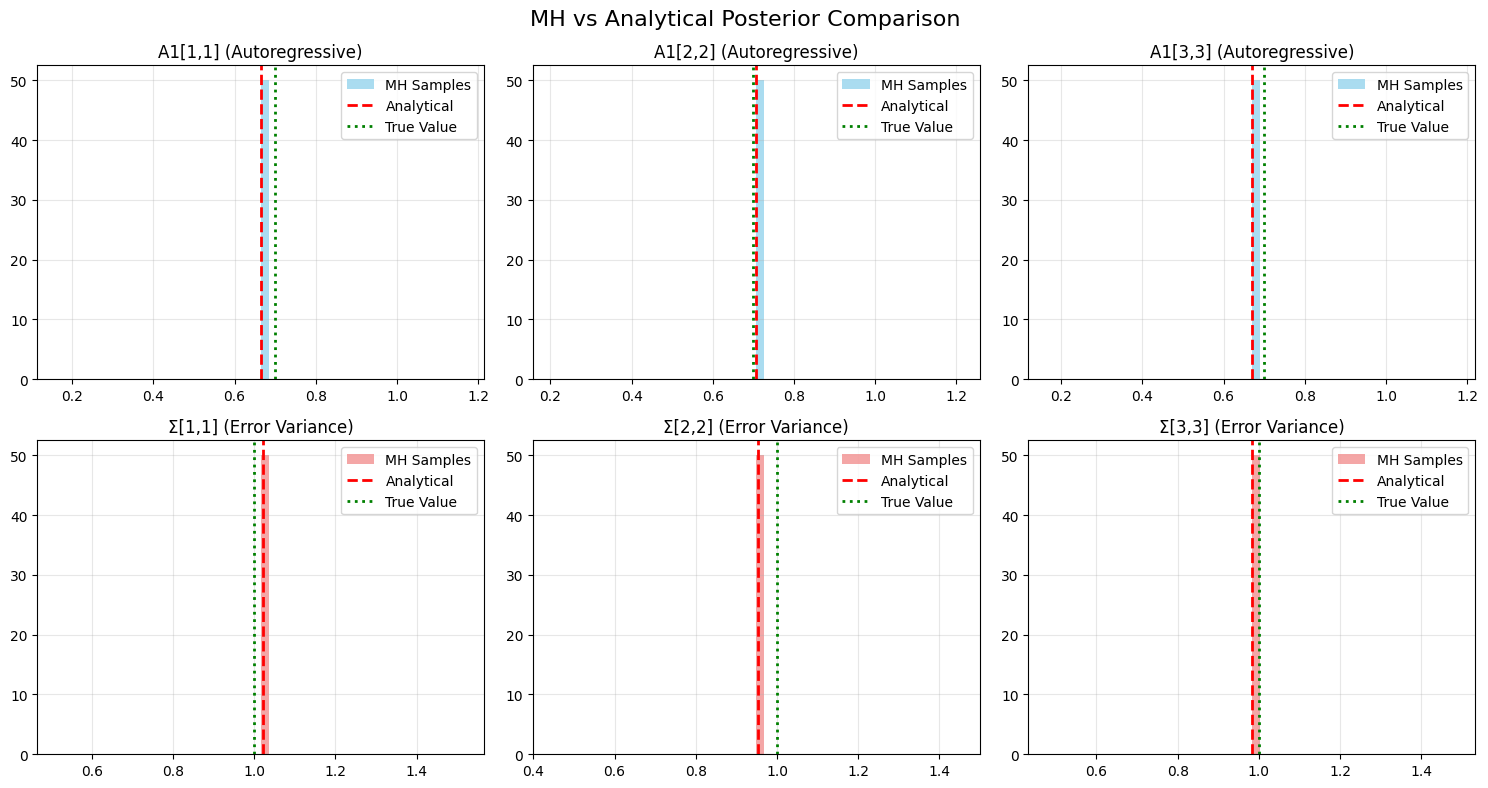


Numerical Comparison:
Parameter		MH Mean		Analytical	Difference
------------------------------------------------------------
A1[1,1]		0.6641		0.6647		0.000604
A1[2,2]		0.7068		0.7073		0.000498
A1[3,3]		0.6695		0.6703		0.000799
Σ[1,1]		1.0159		1.0218		0.005888
Σ[2,2]		0.9489		0.9527		0.003777
Σ[3,3]		0.9824		0.9839		0.001484

VALIDATION COMPLETED!
Effective sample size: 17500
Check plots above for MH vs Analytical comparison


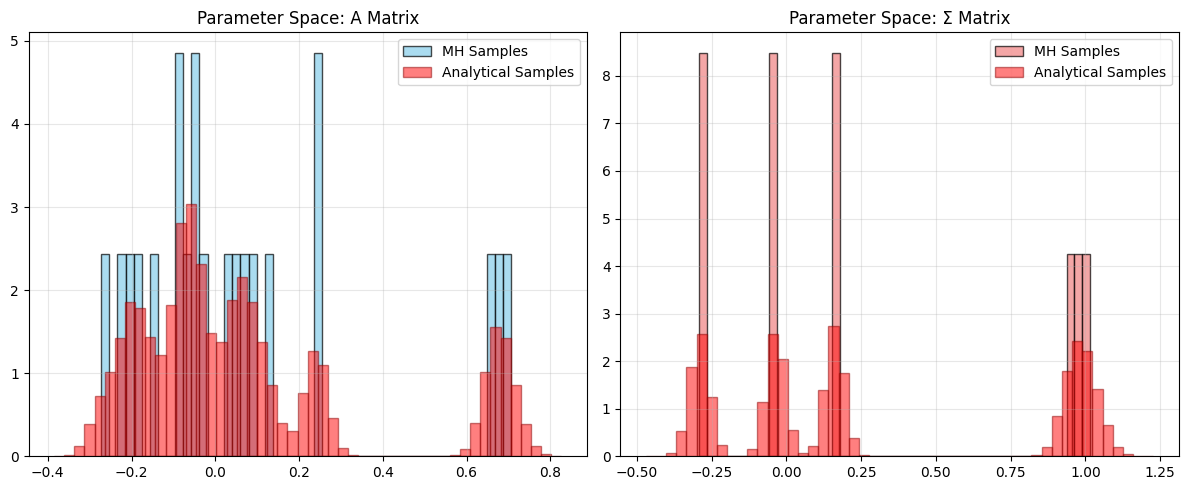

In [3]:
# Metropolis-Hastings for VAR with Minnesota Prior
from scipy.stats import invwishart, multivariate_normal

def log_likelihood_var(A, Sigma, Y_matrix, X_matrix):
    """
    Compute log-likelihood for VAR model
    
    L(A,Σ;Y) = -TN/2 * log(2π) - T/2 * log|Σ| - 1/2 * tr[Σ^(-1)(Y-XA)'(Y-XA)]
    """
    T, N = Y_matrix.shape
    
    # Prediction errors
    residuals = Y_matrix - X_matrix @ A
    
    # Log determinant of Sigma
    sign, logdet_Sigma = np.linalg.slogdet(Sigma)
    if sign <= 0:
        return -np.inf  # Invalid covariance matrix
    
    # Quadratic form
    Sigma_inv = linalg.inv(Sigma)
    quad_form = np.trace(Sigma_inv @ residuals.T @ residuals)
    
    # Log-likelihood
    log_lik = -0.5 * T * N * np.log(2 * np.pi) - 0.5 * T * logdet_Sigma - 0.5 * quad_form
    
    return log_lik

def log_prior_minnesota(A, Sigma, A_bar, V, S_prior, nu):
    """
    Compute log-prior for Minnesota specification
    
    p(A,Σ) ∝ |Σ|^(-(ν+N+K+1)/2) * exp(-1/2 * tr[Σ^(-1)(A-Ā)'V^(-1)(A-Ā)])
                                  * exp(-1/2 * tr[Σ^(-1)S])
    """
    K, N = A.shape
    
    # Log determinant term
    sign, logdet_Sigma = np.linalg.slogdet(Sigma)
    if sign <= 0:
        return -np.inf
    
    log_det_term = -0.5 * (nu + N + K + 1) * logdet_Sigma
    
    # Quadratic form for A
    A_diff = A - A_bar
    V_inv = linalg.inv(V)
    Sigma_inv = linalg.inv(Sigma)
    
    quad_A = np.trace(Sigma_inv @ A_diff.T @ V_inv @ A_diff)
    quad_A_term = -0.5 * quad_A
    
    # Trace term for S
    trace_S = np.trace(Sigma_inv @ S_prior)
    trace_S_term = -0.5 * trace_S
    
    log_prior = log_det_term + quad_A_term + trace_S_term
    
    return log_prior

def log_posterior_var(A, Sigma, Y_matrix, X_matrix, A_bar, V, S_prior, nu):
    """Compute log-posterior = log-likelihood + log-prior"""
    log_lik = log_likelihood_var(A, Sigma, Y_matrix, X_matrix)
    log_prior = log_prior_minnesota(A, Sigma, A_bar, V, S_prior, nu)
    
    return log_lik + log_prior

def propose_A_mvn(A_current, Sigma_current, proposal_cov_A):
    """
    Propose new A using Matric-Variate Normal with Kronecker structure
    """
    K, N = A_current.shape
    
    # Kronecker structure: Σ ⊗ V_proposal
    cov_full = np.kron(Sigma_current, proposal_cov_A)
    
    # Sample from MVN
    vec_A_current = A_current.flatten()
    vec_A_proposed = multivariate_normal.rvs(vec_A_current, cov_full)
    A_proposed = vec_A_proposed.reshape(K, N)
    
    return A_proposed

def propose_Sigma_invwishart(Sigma_current, proposal_nu, proposal_scale_factor=1.0):
    """
    Propose new Sigma using Inverse Wishart centered at current value
    """
    N = Sigma_current.shape[0]
    
    # Scale matrix centered at current Sigma
    Psi_prop = Sigma_current * (proposal_nu - N - 1) * proposal_scale_factor
    
    # Sample from Inverse Wishart
    try:
        Sigma_proposed = invwishart.rvs(df=proposal_nu, scale=Psi_prop)
        return Sigma_proposed
    except:
        # If sampling fails, return current value (will be rejected)
        return Sigma_current

def acceptance_probability(A_prop, Sigma_prop, A_curr, Sigma_curr, 
                         Y_matrix, X_matrix, A_bar, V, S_prior, nu):
    """Compute Metropolis-Hastings acceptance probability"""
    
    # Log-posterior for proposed values
    log_post_prop = log_posterior_var(A_prop, Sigma_prop, Y_matrix, X_matrix, 
                                     A_bar, V, S_prior, nu)
    
    # Log-posterior for current values
    log_post_curr = log_posterior_var(A_curr, Sigma_curr, Y_matrix, X_matrix,
                                     A_bar, V, S_prior, nu)
    
    # MH ratio (assuming symmetric proposals)
    log_alpha = log_post_prop - log_post_curr
    
    # Return acceptance probability
    return min(1.0, np.exp(log_alpha))

def adaptive_tune_proposals(acceptance_history, proposal_params, iteration, window_size=100):
    """Adaptively tune proposal covariances during burn-in"""
    
    if iteration > window_size and iteration % 50 == 0:
        recent_acceptance = np.mean(acceptance_history[-window_size:])
        
        # Target acceptance rate around 25% for high-dimensional problems
        if recent_acceptance < 0.15:
            # Too low → decrease step size
            proposal_params['cov_A'] *= 0.9
            proposal_params['scale_factor'] *= 0.9
        elif recent_acceptance > 0.4:
            # Too high → increase step size
            proposal_params['cov_A'] *= 1.1
            proposal_params['scale_factor'] *= 1.1
    
    return proposal_params

def metropolis_hastings_var(Y_matrix, X_matrix, A_bar, V, S_prior, nu,
                           n_trials=10000, burn_in=2000, thin=1,
                           initial_A=None, initial_Sigma=None):
    """
    Main Metropolis-Hastings algorithm for VAR with Minnesota prior
    """
    T, N = Y_matrix.shape
    K = X_matrix.shape[1]
    
    # Initialize parameters
    if initial_A is None:
        # OLS estimate as starting point
        A_current = linalg.inv(X_matrix.T @ X_matrix) @ X_matrix.T @ Y_matrix
    else:
        A_current = initial_A.copy()
    
    if initial_Sigma is None:
        residuals = Y_matrix - X_matrix @ A_current
        Sigma_current = (residuals.T @ residuals) / T
    else:
        Sigma_current = initial_Sigma.copy()
    
    # Proposal parameters
    proposal_params = {
        'cov_A': 0.01 * np.eye(K),
        'nu_Sigma': N + 2,
        'scale_factor': 1.0
    }
    
    # Storage
    n_samples = (n_trials - burn_in) // thin
    A_samples = np.zeros((n_samples, K, N))
    Sigma_samples = np.zeros((n_samples, N, N))
    acceptance_history = []
    
    print(f"Starting MH sampling: {n_trials} trials, {burn_in} burn-in, thin={thin}")
    print(f"Expected samples: {n_samples}")
    
    sample_idx = 0
    for iteration in range(n_trials):
        
        # Progress indicator
        if iteration % 1000 == 0:
            print(f"Iteration {iteration}/{n_trials}")
        
        # Propose new A
        A_proposed = propose_A_mvn(A_current, Sigma_current, proposal_params['cov_A'])
        
        # Propose new Sigma
        Sigma_proposed = propose_Sigma_invwishart(
            Sigma_current, 
            proposal_params['nu_Sigma'], 
            proposal_params['scale_factor']
        )
        
        # Compute acceptance probability
        alpha = acceptance_probability(
            A_proposed, Sigma_proposed, A_current, Sigma_current,
            Y_matrix, X_matrix, A_bar, V, S_prior, nu
        )
        
        # Accept/Reject
        accepted = np.random.rand() < alpha
        acceptance_history.append(accepted)
        
        if accepted:
            A_current = A_proposed
            Sigma_current = Sigma_proposed
        
        # Adaptive tuning during burn-in
        if iteration < burn_in:
            proposal_params = adaptive_tune_proposals(
                acceptance_history, proposal_params, iteration
            )
        
        # Store post burn-in samples
        if iteration >= burn_in and (iteration - burn_in) % thin == 0:
            A_samples[sample_idx] = A_current.copy()
            Sigma_samples[sample_idx] = Sigma_current.copy()
            sample_idx += 1
    
    # Final acceptance rate
    final_acceptance_rate = np.mean(acceptance_history[-1000:])
    print(f"Final acceptance rate: {final_acceptance_rate:.3f}")
    
    return A_samples, Sigma_samples

def analytical_posterior_wozniak(Y_matrix, X_matrix, A_bar, V, S_prior, nu):
    """
    Compute analytical posterior parameters following Wozniak (2016)
    
    Returns posterior means for validation
    """
    # Posterior parameters (equations 25 in Wozniak)
    V_post = linalg.inv(linalg.inv(V) + X_matrix.T @ X_matrix)
    A_post = V_post @ (linalg.inv(V) @ A_bar + X_matrix.T @ Y_matrix)
    
    nu_post = nu + Y_matrix.shape[0]
    S_post = S_prior + Y_matrix.T @ Y_matrix + A_bar.T @ linalg.inv(V) @ A_bar - A_post.T @ linalg.inv(V_post) @ A_post
    
    # Posterior means
    A_mean = A_post
    Sigma_mean = S_post / (nu_post - Y_matrix.shape[1] - 1)  # E[Σ] for Inverse Wishart
    
    return A_mean, Sigma_mean, V_post, S_post, nu_post

def plot_posterior_comparison(mh_samples, analytical_params, true_params=None):
    """
    Plot comparison between MH samples and analytical posterior
    """
    A_samples, Sigma_samples = mh_samples
    A_analytical, Sigma_analytical = analytical_params[:2]
    
    n_samples, K, N = A_samples.shape
    
    # Unpack true parameters if provided
    A_true_full = None
    Sigma_true = None
    if true_params is not None:
        A_true_full, Sigma_true = true_params
    
    # Create subplot grid
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    
    # Plot key A parameters (first lag autoregressive coefficients)
    for i in range(min(3, N)):
        ax = axes[0, i]
        
        # MH samples (diagonal of A1)
        a_param_idx = 1 + i  # A1 diagonal elements start at index 1
        mh_values = A_samples[:, a_param_idx, i]
        analytical_value = A_analytical[a_param_idx, i]
        
        # Histogram
        ax.hist(mh_values, bins=50, density=True, alpha=0.7, 
                label='MH Samples', color='skyblue')
        
        # Analytical value
        ax.axvline(analytical_value, color='red', linewidth=2, 
                   label='Analytical', linestyle='--')
        
        # True value if available
        if A_true_full is not None:
            true_value = A_true_full[a_param_idx, i]
            ax.axvline(true_value, color='green', linewidth=2,
                      label='True Value', linestyle=':')
        
        ax.set_title(f'A1[{i+1},{i+1}] (Autoregressive)')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Plot key Sigma parameters (diagonal elements)
    for i in range(min(3, N)):
        ax = axes[1, i]
        
        # MH samples
        mh_values = Sigma_samples[:, i, i]
        analytical_value = Sigma_analytical[i, i]
        
        # Histogram
        ax.hist(mh_values, bins=50, density=True, alpha=0.7,
                label='MH Samples', color='lightcoral')
        
        # Analytical value
        ax.axvline(analytical_value, color='red', linewidth=2,
                   label='Analytical', linestyle='--')
        
        # True value if available
        if Sigma_true is not None:
            true_value = Sigma_true[i, i]
            ax.axvline(true_value, color='green', linewidth=2,
                      label='True Value', linestyle=':')
        
        ax.set_title(f'Σ[{i+1},{i+1}] (Error Variance)')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('MH vs Analytical Posterior Comparison', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Print numerical comparison
    print("\nNumerical Comparison:")
    print("=" * 40)
    print("Parameter\t\tMH Mean\t\tAnalytical\tDifference")
    print("-" * 60)
    
    for i in range(N):
        a_idx = 1 + i
        mh_mean = np.mean(A_samples[:, a_idx, i])
        analytical_val = A_analytical[a_idx, i]
        diff = abs(mh_mean - analytical_val)
        print(f"A1[{i+1},{i+1}]\t\t{mh_mean:.4f}\t\t{analytical_val:.4f}\t\t{diff:.6f}")
    
    for i in range(N):
        mh_mean = np.mean(Sigma_samples[:, i, i])
        analytical_val = Sigma_analytical[i, i]
        diff = abs(mh_mean - analytical_val)
        print(f"Σ[{i+1},{i+1}]\t\t{mh_mean:.4f}\t\t{analytical_val:.4f}\t\t{diff:.6f}")

# =============================================================================
# IMPLEMENTATION
# =============================================================================

# Set number of MCMC trials
n_trials = 50000      # Configurable MCMC iterations
burn_in = 15000       # Burn-in period
thin = 2             # Thinning interval

print("Starting Metropolis-Hastings VAR Estimation")
print("=" * 50)

# Run MH algorithm
A_samples, Sigma_samples = metropolis_hastings_var(
    Y_matrix, X_matrix, A_bar, V, S_prior, nu,
    n_trials=n_trials, burn_in=burn_in, thin=thin
)

print(f"\nMH Sampling completed: {len(A_samples)} samples obtained")

# Compute analytical posterior
print("Computing analytical posterior (Wozniak 2016)...")
A_analytical, Sigma_analytical, V_post, S_post, nu_post = analytical_posterior_wozniak(
    Y_matrix, X_matrix, A_bar, V, S_prior, nu
)

print("Analytical posterior computed successfully")

# Create comparison plot
print("Generating comparison plot...")

# Reshape true parameters for comparison (from data simulation)
from scipy.stats import describe

# Get true parameters in proper format
A_true_full = np.zeros((X_matrix.shape[1], N))
A_true_full[0, :] = mu_true  # Constants
for lag in range(p):
    start_idx = 1 + lag * N
    end_idx = 1 + (lag + 1) * N
    A_true_full[start_idx:end_idx, :] = A_true[:, :, lag]

plot_posterior_comparison(
    mh_samples=(A_samples, Sigma_samples),
    analytical_params=(A_analytical, Sigma_analytical),
    true_params=(A_true_full, Sigma_true)
)

print("\n" + "=" * 50)
print("VALIDATION COMPLETED!")
print(f"Effective sample size: {len(A_samples)}")
print("Check plots above for MH vs Analytical comparison")
print("=" * 50)



# Plot Histogram parameter space
def plot_parameter_space_histograms_fixed(mh_samples, analytical_params):
    """
    Plot parameter space histograms with proper theoretical distribution
    """
    A_samples, Sigma_samples = mh_samples
    A_analytical, Sigma_analytical, V_post, S_post, nu_post = analytical_params
    
    # Flatten MH samples
    all_A_mh = A_samples.flatten()
    all_Sigma_mh = Sigma_samples.flatten()
    
    n_mh_samples = A_samples.shape[0]
    
    # CORRECT: Sample from actual analytical posterior
    A_theoretical_samples = []
    Sigma_theoretical_samples = []
    
    for _ in range(n_mh_samples):
        # Sample Sigma from Inverse Wishart
        Sigma_sample = invwishart.rvs(df=nu_post, scale=S_post)
        
        # Sample A from Matrix Normal given Sigma
        A_sample = np.random.multivariate_normal(
            A_analytical.flatten(), 
            np.kron(Sigma_sample, V_post)
        ).reshape(A_analytical.shape)
        
        A_theoretical_samples.append(A_sample.flatten())
        Sigma_theoretical_samples.append(Sigma_sample.flatten())
    
    all_A_theoretical = np.concatenate(A_theoretical_samples)
    all_Sigma_theoretical = np.concatenate(Sigma_theoretical_samples)
    
    # Plot (same as before)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    axes[0].hist(all_A_mh, bins=50, density=True, alpha=0.7, 
                 color='skyblue', label='MH Samples', edgecolor='black')
    axes[0].hist(all_A_theoretical, bins=50, density=True, alpha=0.5,
                 color='red', label='Analytical Samples', edgecolor='darkred')
    axes[0].set_title('Parameter Space: A Matrix')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].hist(all_Sigma_mh, bins=50, density=True, alpha=0.7,
                 color='lightcoral', label='MH Samples', edgecolor='black')
    axes[1].hist(all_Sigma_theoretical, bins=50, density=True, alpha=0.5,
                 color='red', label='Analytical Samples', edgecolor='darkred')
    axes[1].set_title('Parameter Space: Σ Matrix')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Implementation
plot_parameter_space_histograms_fixed(
    mh_samples=(A_samples, Sigma_samples),
    analytical_params=(A_analytical, Sigma_analytical, V_post, S_post, nu_post)
)


